# Sparse vs Dense classification


Which classification methods work better for dense and sparse data? This project will use real data sets to compare Logistic Regression vs Sparse Logistic Regression from glmnet. I use datasets appropriate for binary classification so that sensitivity and specificity can be used to measure the results. The code is in this file, and the interpretation is in the pdf.

In [1]:
library(glmnet)
library(plyr)
library(corrplot)
#library(caret) # sensitivity, specificity --messes up glmnet graphing when it's loaded

Warning message:
"package 'glmnet' was built under R version 3.6.3"Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.6.3"Loaded glmnet 4.1-1
Warning message:
"package 'plyr' was built under R version 3.6.3"corrplot 0.90 loaded


In [2]:
breast_cancer<-read.csv("breast-cancer-Wisconsin.data", header=FALSE)
breast_cancer <-rename(breast_cancer, c("V1"="id", "V2"="thickness", "V3" = "uni_size", "V4" = "uni_shape", 
                       "V5" = "adhesion", "V6"="epi_size", "V7" = "bare_nuclei", 
                       "V8" = "bland_chroma", "V9"="normal_nuc", "V10"="mitosis", 
                       "V11" = "class"))

# bare nuclei was being read as a categorical variable
breast_cancer$bare_nuclei <-as.numeric(breast_cancer$bare_nuclei)

#logistic regression wants 0 and 1 instead of 2 and 4
breast_cancer$class <- as.character(breast_cancer$class)
breast_cancer$class[breast_cancer$class == "2"] <- "0"
breast_cancer$class[breast_cancer$class == "4"] <- "1"
breast_cancer$class <- as.numeric(breast_cancer$class)

#summary(breast_cancer)
#dim(breast_cancer)
#head(breast_cancer)

# for glmnet
x_matrix <- model.matrix( ~ thickness + uni_size + uni_shape + adhesion + epi_size 
                  + bare_nuclei + bland_chroma + normal_nuc + mitosis - 1, breast_cancer)
y <- breast_cancer$clas
#any(is.na(X)) # there are no nas

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

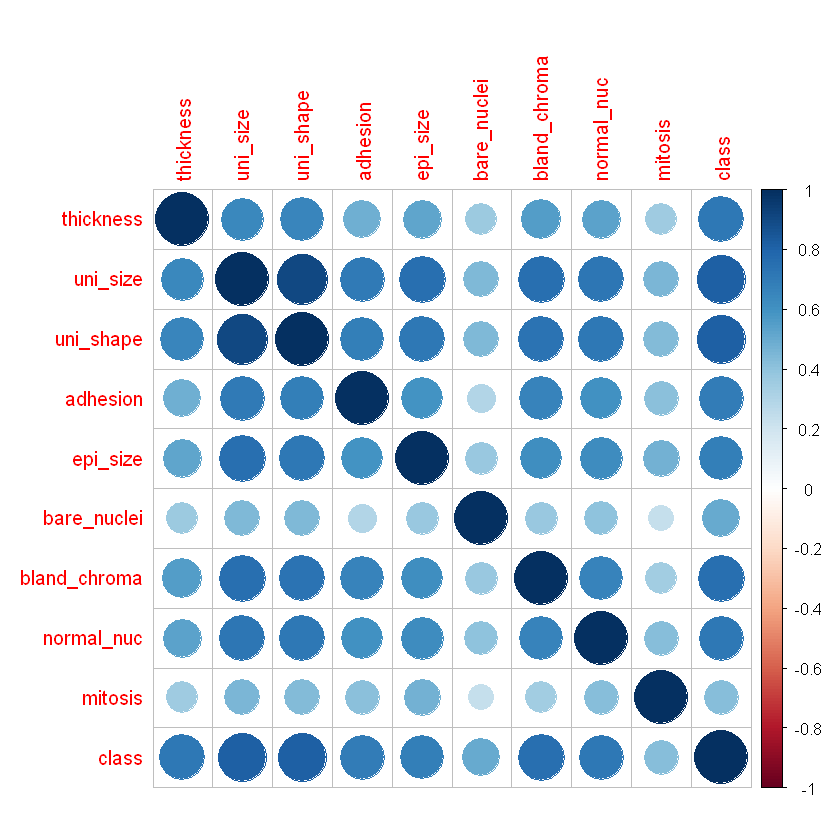

In [3]:
correlations <- cor(breast_cancer[,-1])
corrplot(correlations, method="circle")

In [4]:
# Logistic Regression
logistic_bc <- glm(class ~ thickness + uni_size + adhesion + epi_size + bare_nuclei 
                + bland_chroma + normal_nuc + mitosis, data = breast_cancer, 
                family=binomial(link='logit'))

#summary(logistic_bc)

anova(logistic_bc, test="Chisq")

threshold = 0.5
fitted.results <- predict(logistic_bc,type='response')
fitted.results <- ifelse(fitted.results > threshold,1,0)

misClassificError <- mean(fitted.results != breast_cancer$class)
misClassificError

predicted_values <- ifelse(predict(logistic_bc,type="response") > threshold,1,0)
actual_values <- breast_cancer$class
conf_matrix <- table(predicted_values,actual_values)
conf_matrix


#sensitivity(conf_matrix)
#specificity(conf_matrix)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,698,900.5274,NA
thickness,1,436.473481,697,464.0540,6.338108e-97
uni_size,1,251.747248,696,212.3067,1.080262e-56
adhesion,1,22.413970,695,189.8927,2.197697e-06
epi_size,1,9.437713,694,180.4550,2.125684e-03
bare_nuclei,1,15.481715,693,164.9733,8.330725e-05
bland_chroma,1,20.770283,692,144.2030,5.178023e-06
normal_nuc,1,1.523235,691,142.6798,2.171307e-01
mitosis,1,3.606688,690,139.0731,5.754763e-02


[1] 0.04291845

                actual_values
predicted_values   0   1
               0 444  16
               1  14 225

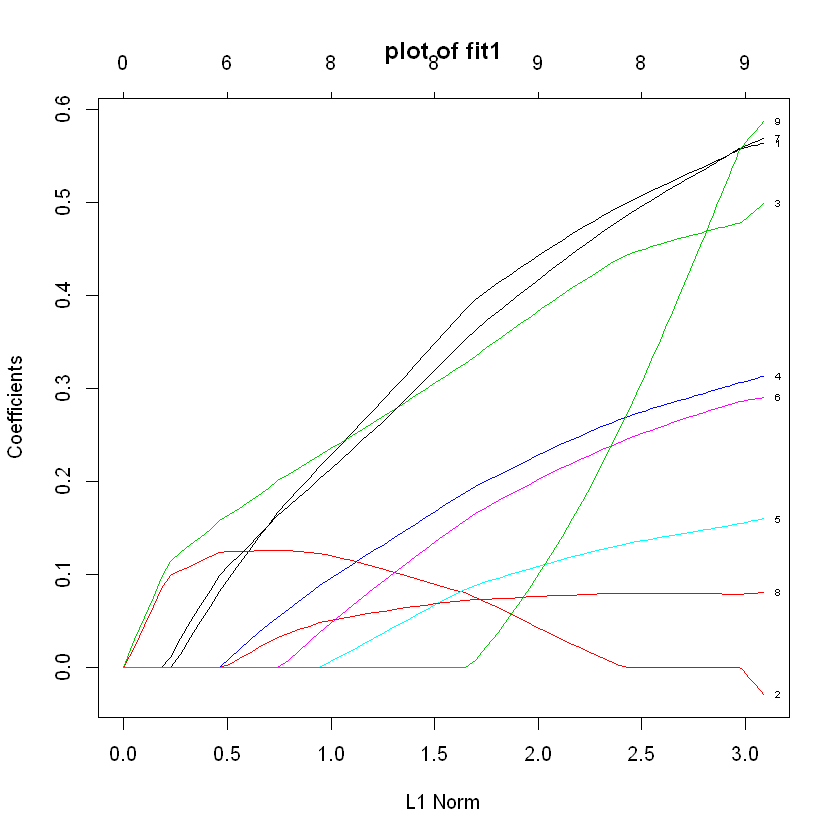

In [5]:
# The input must be a matrix, not a data frame
fit = glmnet(x_matrix, y, family="binomial")
plot(fit, main="plot of fit1", label=TRUE)
#coef(fit)

In [6]:
cvfit = cv.glmnet(x_matrix, y, family = "binomial", type.measure = "class")
# find best lambda as measured by misclassification error
cvfit


Call:  cv.glmnet(x = x_matrix, y = y, type.measure = "class", family = "binomial") 

Measure: Misclassification Error 

      Lambda Index Measure       SE Nonzero
min 0.000764    68 0.04006 0.009706       8
1se 0.031572    28 0.04864 0.010467       8

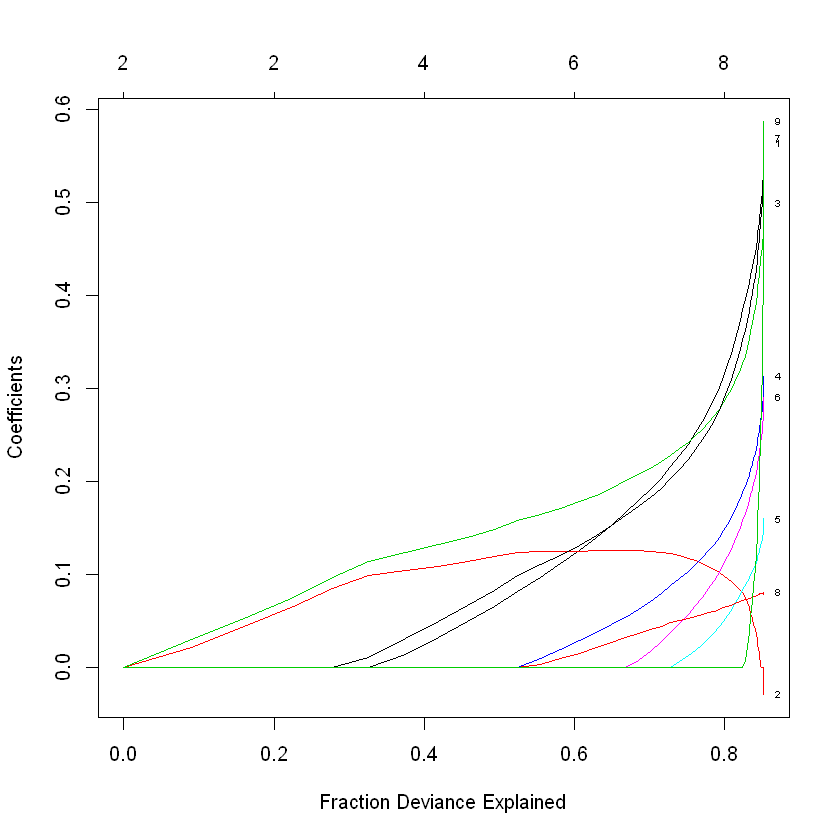

In [7]:
plot(fit, xvar = "dev", label = TRUE)

In [8]:
coef(cvfit, s = "lambda.min")
# the coefficients of the final model -- all are included

10 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  -10.28442983
thickness      0.54792491
uni_size       .         
uni_shape      0.47326596
adhesion       0.30077792
epi_size       0.15157869
bare_nuclei    0.28059452
bland_chroma   0.54731284
normal_nuc     0.07911499
mitosis        0.51364206

In [9]:
pred <- predict(cvfit, x_matrix, s = "lambda.min", type = "class") 
actual_values <- breast_cancer$class
conf_matrix <- table(pred,actual_values)
conf_matrix

    actual_values
pred   0   1
   0 444  13
   1  14 228

In [10]:
CAD <- read.csv("Z-Alizadeh _sani_dataset.csv")
#summary(CAD)
#dim(CAD)

# remove non-numeric variables for correlation plot
numeric_CAD <- CAD[,-4] 
numeric_CAD <- numeric_CAD[, -c(10:16)]
numeric_CAD <- numeric_CAD[, -c(13:16)]
numeric_CAD <- numeric_CAD[, -14]
numeric_CAD <- numeric_CAD[, -c(15:18)]
numeric_CAD <- numeric_CAD[, -c(19:21)]
numeric_CAD <- numeric_CAD[, -c(35:36)]

# for glmnet
x_matrix_CAD <- model.matrix( ~ Age + Weight + Length + Sex + BMI + DM + HTN 
                + Current.Smoker + EX.Smoker + FH + Obesity + CRF + CVA + Airway.disease 
                + Thyroid.Disease + CHF + DLP + BP + PR + Edema + Weak.Peripheral.Pulse 
                + Lung.rales + Systolic.Murmur + Diastolic.Murmur + Typical.Chest.Pain
                + Dyspnea + Function.Class + Atypical + Nonanginal #+ Exertional.CP - everything is uniform
                + LowTH.Ang + Q.Wave+ St.Elevation + St.Depression + Tinversion
                + LVH + Poor.R.Progression + BBB + FBS + CR + TG + LDL + HDL + BUN 
                + ESR + HB + K + Na + WBC + Lymph + Neut + PLT + EF.TTE + Region.RWMA + VHD - 1 
                , CAD)
y_CAD <- CAD$Cath

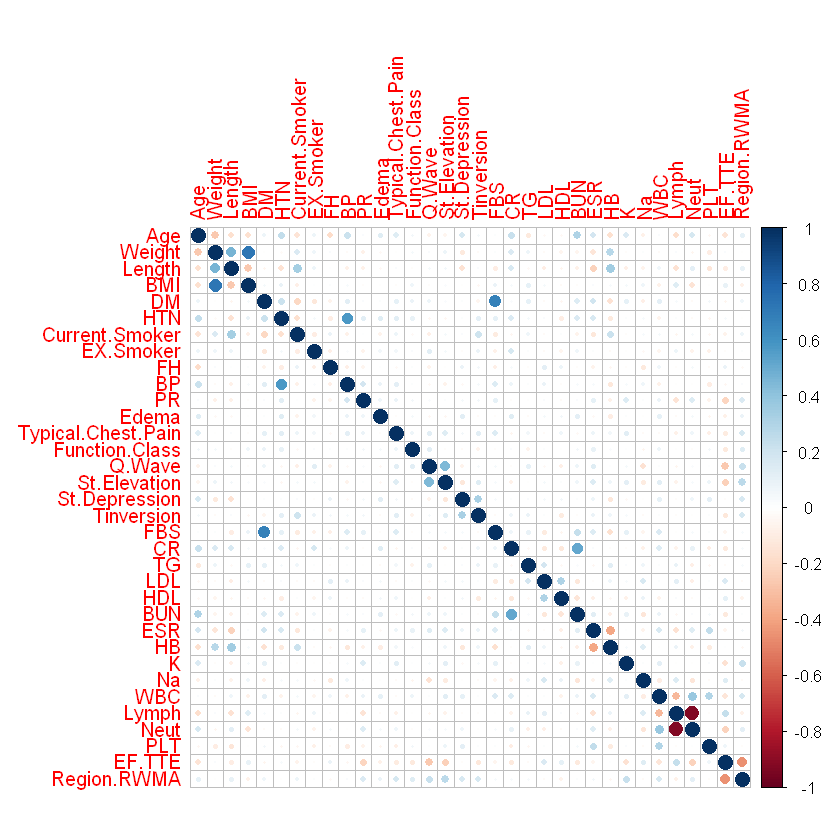

In [11]:
# CAD corrplot
correlations <- cor(numeric_CAD)
corrplot(correlations, method="circle")

In [12]:
# Logistic Regression
logistic_cad <- glm(Cath ~ Age + Weight + Length + Sex + BMI + DM + HTN 
                + Current.Smoker + EX.Smoker + FH + Obesity + CRF + CVA + Airway.disease 
                + Thyroid.Disease + CHF + DLP + BP + PR + Edema + Weak.Peripheral.Pulse 
                + Lung.rales + Systolic.Murmur + Diastolic.Murmur + Typical.Chest.Pain
                + Dyspnea + Function.Class + Atypical + Nonanginal #+ Exertional.CP - everything is uniform
                + LowTH.Ang + Q.Wave+ St.Elevation + St.Depression + Tinversion
                + LVH + Poor.R.Progression + BBB + FBS + CR + TG + LDL + HDL + BUN 
                + ESR + HB + K + Na + WBC + Lymph + Neut + PLT + EF.TTE + Region.RWMA + VHD
                , data = CAD, family=binomial(link='logit'))

summary(logistic_cad)

#anova(logistic_cad, test="Chisq")

threshold = 0.5
fitted.results <- predict(logistic_cad,type='response')
fitted.results <- ifelse(fitted.results > threshold,1,0)

#misclassification error
#misClassificError <- mean(fitted.results != CAD$Cath)
#misClassificError

# confusion matrix
predicted_values <- ifelse(predict(logistic_cad,type="response") > threshold,1,0)
actual_values <- CAD$Cath
conf_matrix <- table(predicted_values,actual_values)
conf_matrix



#sensitivity(conf_matrix)
#specificity(conf_matrix)


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Cath ~ Age + Weight + Length + Sex + BMI + DM + 
    HTN + Current.Smoker + EX.Smoker + FH + Obesity + CRF + CVA + 
    Airway.disease + Thyroid.Disease + CHF + DLP + BP + PR + 
    Edema + Weak.Peripheral.Pulse + Lung.rales + Systolic.Murmur + 
    Diastolic.Murmur + Typical.Chest.Pain + Dyspnea + Function.Class + 
    Atypical + Nonanginal + LowTH.Ang + Q.Wave + St.Elevation + 
    St.Depression + Tinversion + LVH + Poor.R.Progression + BBB + 
    FBS + CR + TG + LDL + HDL + BUN + ESR + HB + K + Na + WBC + 
    Lymph + Neut + PLT + EF.TTE + Region.RWMA + VHD, family = binomial(link = "logit"), 
    data = CAD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1941  -0.0191  -0.0002   0.0078   2.6880  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)   
(Intercept)            -8.599e+01  5.480e+01  -1.569  0.11657   
Age                    -1.609e-01  5.278e-02  -3.048  0.00230 **
Weight                 -7.666e-01  

                actual_values
predicted_values Cad Normal
               0 207      6
               1   9     81

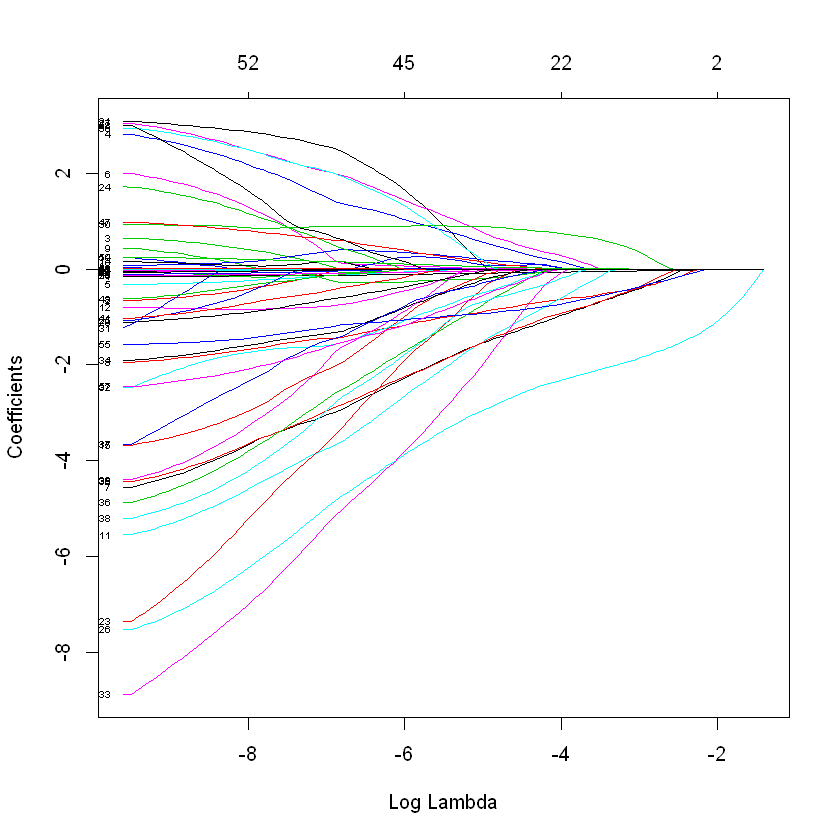

In [13]:
#sparse logistic
# The input must be a matrix, not a data frame
fit = glmnet(x_matrix_CAD, y_CAD, family="binomial")
#plot(fit, main="plot of fit1", label=TRUE)
#coef(fit)
plot(fit, xvar = "lambda", label = TRUE)

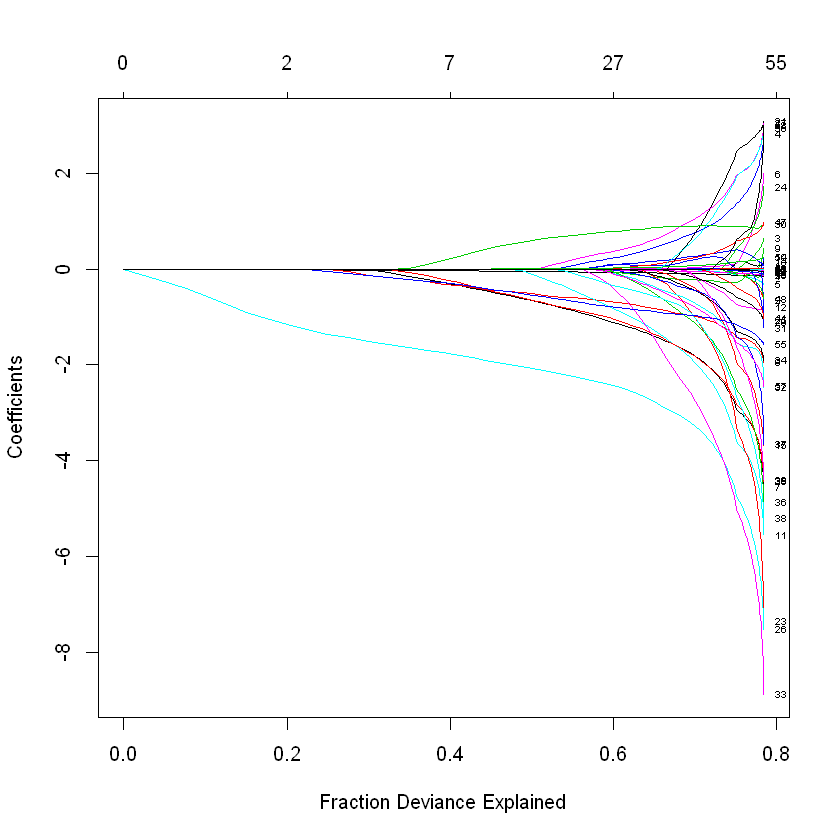

In [14]:
plot(fit, xvar = "dev", label = TRUE)

Warning message in plot.window(...):
""label" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""label" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""label" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""label" is not a graphical parameter"Warning message in box(...):
""label" is not a graphical parameter"Warning message in title(...):
""label" is not a graphical parameter"

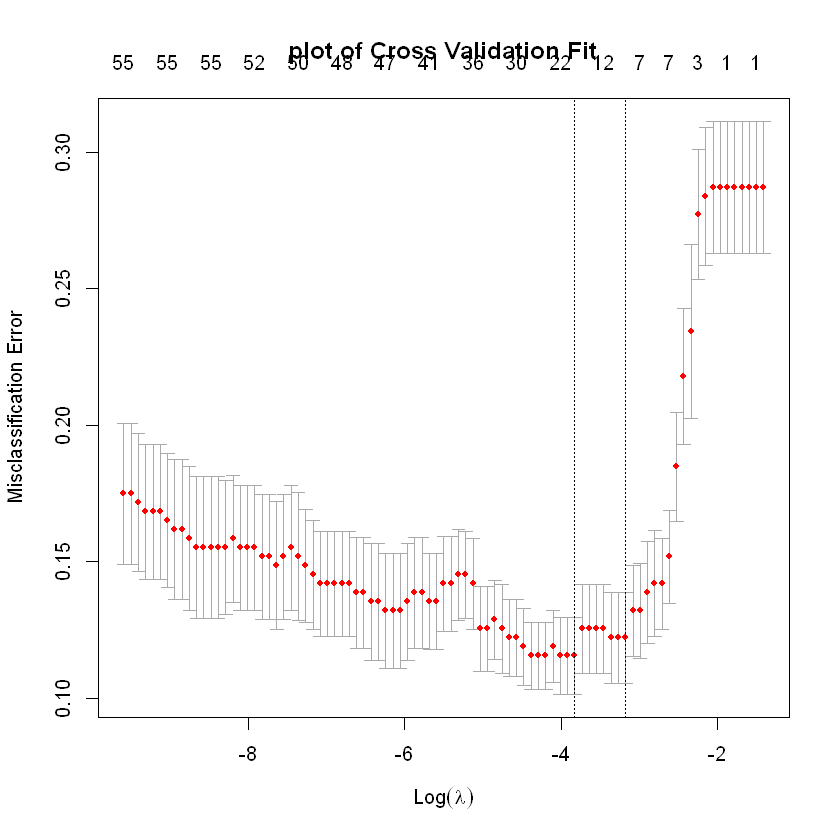

In [15]:
cvfit = cv.glmnet(x_matrix_CAD, y_CAD, family = "binomial", type.measure = "class")
# response” gives the fitted probabilities
# class” produces the class label corresponding to the maximum probability.
# “coefficients” computes the coefficients at values of s
# “nonzero” returns a list of the indices of the nonzero coefficients for each value of s.
#cvfit
plot(cvfit, main="plot of Cross Validation Fit", label=TRUE)

In [16]:
coef(cvfit, s = "lambda.min")

59 x 1 sparse Matrix of class "dgCMatrix"
                                   1
(Intercept)             5.8332496465
Age                    -0.0606614896
Weight                  .           
Length                  .           
SexFmale                0.0776766479
SexMale                -0.0001072502
BMI                     .           
DM                     -0.8713879042
HTN                    -0.6039836332
Current.Smoker          .           
EX.Smoker               .           
FH                     -0.4407955532
ObesityY                .           
CRFY                    .           
CVAY                    .           
Airway.diseaseY         .           
Thyroid.DiseaseY        .           
CHFY                    .           
DLPY                    .           
BP                     -0.0044622079
PR                     -0.0140746923
Edema                   .           
Weak.Peripheral.PulseY  .           
Lung.ralesY             .           
Systolic.MurmurY        .        

In [17]:
# predict classes, make confusion matrix
pred <- predict(cvfit, x_matrix_CAD, s = "lambda.min", type = "class") 
actual_values <- CAD$Cath
conf_matrix <- table(pred,actual_values)
conf_matrix
#the matrix is worse than for logistic regression

        actual_values
pred     Cad Normal
  Cad    204     19
  Normal  12     68